In [21]:
import tensorflow as tf
import numpy as np
import time
import math
import pickle
import datetime
import collections
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, GRU, Dense, Dropout, Activation
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard, LearningRateScheduler, ModelCheckpoint
import tensorflow.keras.backend as K

In [22]:
import os.path
if not(os.path.isfile('ptb.zip')):
  !wget -O ptb.zip https://www.dropbox.com/s/bs9ztyq27sxa3l7/ptb.zip?dl=0
!unzip -o ptb.zip

Archive:  ptb.zip
  inflating: ptb.train.txt           
  inflating: ptb.valid.txt           
  inflating: ptb.test.txt            


## Download all pre-trained models, weights and history:

In [23]:
if not(os.path.isfile('GRU.zip')):
  !wget -O GRU.zip https://www.dropbox.com/s/f9iyf0x6jmorgjt/GRU2.zip?dl=0
!unzip -o GRU.zip

if not(os.path.isfile('LSTM.zip')):
  !wget -O LSTM.zip https://www.dropbox.com/s/9fjnwgqy6kzm5rc/LSTM2.zip?dl=0
!unzip -o LSTM.zip

Archive:  GRU.zip
  inflating: GRU_Drop.weights.hdf5   
  inflating: GRU_No_Drop.weights.hdf5  
  inflating: trainHistoryGRU         
Archive:  LSTM.zip
  inflating: LSTM_Drop.weights.hdf5  
  inflating: LSTM_No_Drop.weights.hdf5  
  inflating: trainHistoryLSTM        


## Define Hyperparameters:

In [24]:
batch_size = 20
seq_len = 25
clip_norm = 5
learning_rate = 3.
decay = 0.98
epochs = 100
epochs_no_decay = 15
drop_out_rate = 0.3
hidden_size = 200

## Define Custom Method for Features and Labels Creation from sequence:

In [25]:
# Based on Git Repo by @tmatha (2018)
# Modified based on MIT License
def features_labels(data_array, batch_size, seq_len, batch_first=True):  
  if len(data_array.shape) != 1:
    raise ValueError('Expected 1-d data array, '
                     'instead data array shape is {} '.format(data_array.shape))
  
  def fold(used_array):
    shaped_array=np.reshape(used_array,(batch_size,seq_len*steps),order='C')    
    if batch_first:
      return np.concatenate(np.split(shaped_array,steps,axis=1),axis=0)
    else:
      return np.transpose(shaped_array)

  steps = (data_array.shape[0]-1)//(batch_size*seq_len)
  used = batch_size * seq_len * steps  
  features = fold(data_array[:used])
  labels   = fold(data_array[1:used+1])
  
  Data = collections.namedtuple('Data',['features','labels'])
  return Data(features=features,labels=labels), steps

## Create Sequences:

In [26]:
seq = {'train': [], 'valid': [], 'test': []}
for seq_type in seq.keys():
  with open('ptb.'+ seq_type + '.txt','r') as cur_file:
      cur_seq = cur_file.read().replace('\n','<eos>').split(' ')
  cur_seq = list(filter(None, cur_seq))
  print(f'First ten in {seq_type} sequence: {cur_seq[:10]}')
  print(f'Size of {seq_type} sequence: {len(cur_seq)}')
  seq[seq_type] = cur_seq

First ten in train sequence: ['aer', 'banknote', 'berlitz', 'calloway', 'centrust', 'cluett', 'fromstein', 'gitano', 'guterman', 'hydro-quebec']
Size of train sequence: 929589
First ten in valid sequence: ['consumers', 'may', 'want', 'to', 'move', 'their', 'telephones', 'a', 'little', 'closer']
Size of valid sequence: 73760
First ten in test sequence: ['no', 'it', 'was', "n't", 'black', 'monday', '<eos>', 'but', 'while', 'the']
Size of test sequence: 82430


## Create the Vocabulary and Datasets:

In [27]:
vocab_train = set(seq['train'])
vocab_valid = set(seq['valid'])
vocab_test  = set(seq['test'])

assert vocab_valid.issubset(vocab_train)
assert vocab_test.issubset(vocab_train)
print(f'Train vocabulary length: {len(vocab_train)}')
print(f'Valid vocabulary length: {len(vocab_valid)}')
print(f'Test vocabulary length: {len(vocab_test)}')

vocab_train = sorted(vocab_train)
word2id = {w:i for i,w in enumerate(vocab_train)}
id2word = {i:w for i,w in enumerate(vocab_train)}

Train vocabulary length: 10000
Valid vocabulary length: 6022
Test vocabulary length: 6049


In [28]:
ids_train = np.array([word2id[word] for word in seq['train']], copy=False, order='C')
ids_valid = np.array([word2id[word] for word in seq['valid']], copy=False, order='C')
ids_test  = np.array([word2id[word] for word in seq['test']], copy=False, order='C')

data_train, steps_train = features_labels(
    ids_train, batch_size, seq_len, batch_first=True)
data_valid, steps_valid = features_labels(
    ids_valid, batch_size, seq_len, batch_first=True)
data_test, steps_test = features_labels(
    ids_test, batch_size, seq_len, batch_first=True)

print(f'Steps Train: {steps_train}')
print(f'Steps Validation: {steps_valid}')
print(f'Steps Test: {steps_test}')

Steps Train: 1859
Steps Validation: 147
Steps Test: 164


In [29]:
dataset_train = tf.data.Dataset.from_tensor_slices(data_train).batch(batch_size,
    drop_remainder=True)
dataset_valid = tf.data.Dataset.from_tensor_slices(data_valid).batch(batch_size,
    drop_remainder=True)
dataset_test = tf.data.Dataset.from_tensor_slices(data_test).batch(batch_size,
    drop_remainder=True)

In [30]:
# Check the dataset's shapes, input and target:
for input_example_batch, target_example_batch in dataset_train.take(1):
    print(f'Shape of input: {input_example_batch.shape}')
    print(f'Shape of target: {target_example_batch.shape}')
    
    print(' '.join([id2word[id] for id in input_example_batch[0].numpy()]))
    print(' '.join([id2word[id] for id in target_example_batch[0].numpy()]))
    print(' '.join([id2word[id] for id in input_example_batch[1].numpy()]))
    print(' '.join([id2word[id] for id in target_example_batch[1].numpy()]))

Shape of input: (20, 25)
Shape of target: (20, 25)
aer banknote berlitz calloway centrust cluett fromstein gitano guterman hydro-quebec ipo kia memotec mlx nahb punts rake regatta rubens sim snack-food ssangyong swapo wachter <eos>
banknote berlitz calloway centrust cluett fromstein gitano guterman hydro-quebec ipo kia memotec mlx nahb punts rake regatta rubens sim snack-food ssangyong swapo wachter <eos> pierre
<unk> on airline acquisitions that would so load a carrier up with debt that it would <unk> safety or a carrier 's ability to compete
on airline acquisitions that would so load a carrier up with debt that it would <unk> safety or a carrier 's ability to compete rep.


## Define LSTM Based Sequential Model Class:


In [31]:
class LSTM_Based(Sequential):
  def __init__(self, name, vocabulary_size, hidden_size, seq_len, Drop=None):
    super().__init__(name = name)
    self.add(Embedding(vocabulary_size, hidden_size, input_length=seq_len))
    if Drop:
      self.add(Dropout(drop_out_rate))
    self.add(LSTM(hidden_size, return_sequences=True))
    if Drop:
      self.add(Dropout(drop_out_rate))
    self.add(LSTM(hidden_size, return_sequences=True))
    if Drop:
      self.add(Dropout(drop_out_rate))
    self.add(Dense(vocabulary_size))
    
class GRU_Based(Sequential):
  def __init__(self, name, vocabulary_size, hidden_size, seq_len, Drop=None):
    super().__init__(name = name)
    self.add(Embedding(vocabulary_size, hidden_size, input_length=seq_len))
    if Drop:
      self.add(Dropout(drop_out_rate))
    self.add(GRU(hidden_size, return_sequences=True))
    if Drop:
      self.add(Dropout(drop_out_rate))
    self.add(GRU(hidden_size, return_sequences=True))
    if Drop:
      self.add(Dropout(drop_out_rate))
    self.add(Dense(vocabulary_size))

## Define Custom Perplexity Metric, Learning Scheduler and Optimizer:

In [32]:
def perplexity(y_true, y_pred):
    cross_entropy = K.mean(K.sparse_categorical_crossentropy(y_true, y_pred, from_logits=True))
    perplexity = K.exp(cross_entropy)
    return perplexity

def lr_decay(epoch, lr):
  if epoch < epochs_no_decay:
    return learning_rate
  else:
    return max(round(lr * decay, 2), 0.01)

def get_callbacks(name):
  log_dir = logdir + "/" + name + "/" + datetime.datetime.now().strftime("%m%d-%H%M")
  file_path = name + '.weights.hdf5'
  checkpointer = ModelCheckpoint(filepath=file_path, verbose = 1, save_best_only=True)
  return [
          LearningRateScheduler(lr_decay, verbose=1),
          TensorBoard(log_dir=log_dir, histogram_freq=1),
          checkpointer
  ]

In [33]:
def create_compile(model_def):
  if model_def['Type'] == 'LSTM':
    model = LSTM_Based(name = model_def['name'],
                       vocabulary_size = len(word2id),
                       hidden_size = model_def['hidden_size'],
                       seq_len = model_def['seq_len'],
                       Drop = model_def['Drop'])
  elif model_def['Type'] == 'GRU':
    model = GRU_Based(name = model_def['name'],
                      vocabulary_size = len(word2id),
                      hidden_size = model_def['hidden_size'],
                      seq_len = model_def['seq_len'],
                      Drop = model_def['Drop'])
    
  optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, clipnorm=clip_norm)
  # optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
  loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
  model.compile(optimizer=optimizer, loss=loss, metrics=[perplexity])
  return model

## Train Models:

In [34]:
model_defs = [
              {'name': 'LSTM_Drop', 'Type': 'LSTM', 'hidden_size': hidden_size, 'seq_len': seq_len, 'Drop': True},
              {'name': 'LSTM_No_Drop', 'Type': 'LSTM', 'hidden_size': hidden_size, 'seq_len': seq_len, 'Drop': False},
              {'name': 'GRU_Drop', 'Type': 'GRU', 'hidden_size': hidden_size, 'seq_len': seq_len, 'Drop': True},
              {'name': 'GRU_No_Drop', 'Type': 'GRU', 'hidden_size': hidden_size, 'seq_len': seq_len, 'Drop': False}
              ]

## Re-Load Models with best weights and evaluate:

In [35]:
results = {}
for model_def in model_defs:
  model = create_compile(model_def)
  model.load_weights(model.name + '.weights.hdf5')

  cur_res = {}
  train_loss, train_perp = model.evaluate(dataset_train, verbose=0)
  valid_loss, valid_perp = model.evaluate(dataset_valid, verbose=0)
  test_loss, test_perp   = model.evaluate(dataset_test, verbose=0)

  cur_res['loss'] = [train_loss, valid_loss, test_loss]
  cur_res['perp'] = [train_perp, valid_perp, test_perp]
  results[model.name] = cur_res

  print(f'\nModel {model.name}:')
  print(f'\tLoss:{[round(el, 2) for el in cur_res["loss"]]}')
  print(f'\tPerp:{[round(el, 2) for el in cur_res["perp"]]}')


Model LSTM_Drop:
	Loss:[3.9, 4.71, 4.65]
	Perp:[50.18, 113.39, 106.36]

Model LSTM_No_Drop:
	Loss:[4.47, 4.98, 4.95]
	Perp:[90.19, 149.03, 143.03]

Model GRU_Drop:
	Loss:[4.07, 4.82, 4.78]
	Perp:[59.71, 127.12, 120.87]

Model GRU_No_Drop:
	Loss:[4.5, 5.04, 5.0]
	Perp:[92.46, 157.19, 150.97]


## Plot the Training and Validation Graphs:

In [36]:
with open('trainHistoryGRU', 'rb') as file:
  historyGRU = pickle.load(file)
with open('trainHistoryLSTM', 'rb') as file:
  historyLSTM = pickle.load(file)
history = {}
history.update(historyGRU)
history.update(historyLSTM)

In [37]:
history.keys()

dict_keys(['GRU_Drop', 'GRU_No_Drop', 'LSTM_Drop', 'LSTM_No_Drop'])

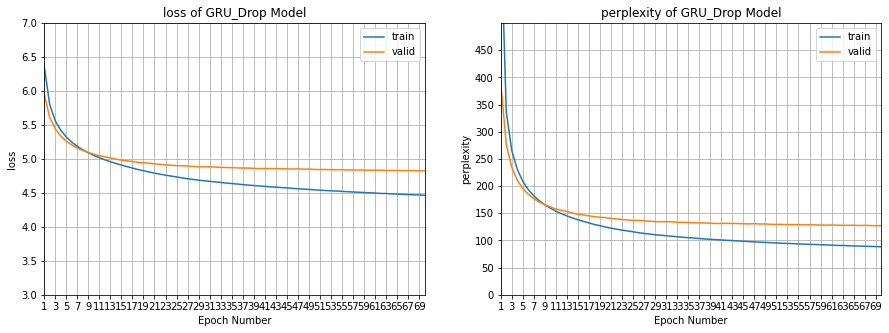

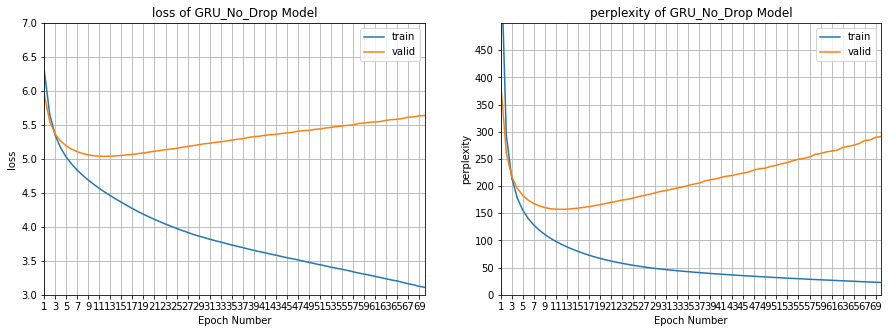

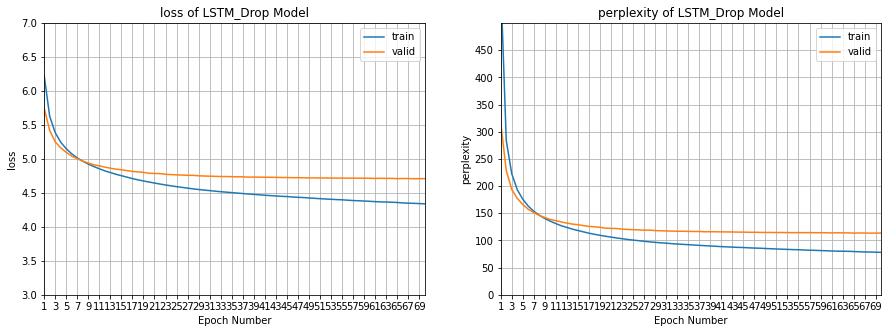

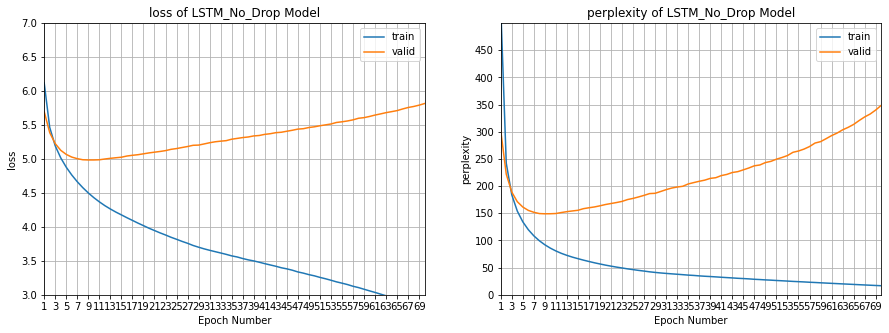

In [38]:
%matplotlib inline
for model_name in history.keys():
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
  hist = history[model_name]
  n_epochs = len(hist['loss'])
  x_skips = max(1, int(n_epochs/25))

  for i in range(2):
    cur_ax = ax1 if i==1 else ax2
    metric = 'loss' if i==1 else 'perplexity'
    y_max = 7 if i==1 else 500
    y_min = 3 if i==1 else 0
    y_skips = 0.5 if i==1 else 50

    plt.sca(cur_ax)
    plt.plot(range(1, n_epochs+1), hist[metric])
    plt.plot(range(1, n_epochs+1), hist[f'val_{metric}'])
    plt.xticks(range(1, n_epochs+2, x_skips), range(1, n_epochs+2, x_skips))
    plt.xlim([1, n_epochs])
    plt.xlabel('Epoch Number')

    if i==0:
      plt.yticks(range(y_min, y_max, y_skips), range(y_min, y_max, y_skips))
    plt.ylim([y_min, y_max])
    plt.ylabel(f'{metric}')
    plt.title(f'{metric} of {model_name} Model')
    plt.legend(['train', 'valid'])
    plt.grid(True)

## Testing Text Prediction for Best Model:

In [39]:
dict_keys = results.keys()
metric = []
names = []
for name in dict_keys:
  names.append(name)
  metric.append(results[name]['perp'][2])

min_val, idx = min((val, idx) for (idx, val) in enumerate(metric))
best_name = names[idx]
print(f'Min Test Set Perplexity of {round(min_val, 2)} achieved by {best_name}')

model_idx =  [model['name'] for model in model_defs].index(best_name)
model_def = model_defs[model_idx]
model = create_compile(model_def)
model.load_weights(model.name + '.weights.hdf5')

Min Test Set Perplexity of 106.36 achieved by LSTM_Drop


In [40]:
num_words = 10
for test_example_batch, target_example_batch in dataset_train.take(1):
    print(f'Shape of input: {test_example_batch.shape}')
    print(f'Shape of target: {target_example_batch.shape}')
    example_batch_predictions = model.predict(test_example_batch)
    # (batch_size, sequence_length, vocab_size)
    print(f'Shape of prediction: {example_batch_predictions.shape}')

print('\nTrain Set Examples:')
print('------')
for test_example_batch, target_example_batch in dataset_train.take(2):
    n_batch = 1
    target = target_example_batch[n_batch].numpy()
    print(' '.join([id2word[id].ljust(8) for id in target[seq_len-num_words:]]))

    example_batch_predictions = model.predict(test_example_batch)
    prediction = tf.nn.softmax(example_batch_predictions[n_batch])
    prediction = np.argmax(prediction, axis=1)
    print(' '.join([id2word[id].ljust(8) for id in prediction[seq_len-num_words:]]))
    print('------')

print('\nTest Set Examples:')
print('------')
for test_example_batch, target_example_batch in dataset_test.take(10):
    target = target_example_batch[0].numpy()
    print(' '.join([id2word[id].ljust(8) for id in target[seq_len-num_words:]]))

    example_batch_predictions = model.predict(test_example_batch)
    prediction = tf.nn.softmax(example_batch_predictions[0])
    prediction = np.argmax(prediction, axis=1)
    print(' '.join([id2word[id].ljust(8) for id in prediction[seq_len-num_words:]]))
    print('------')

Shape of input: (20, 25)
Shape of target: (20, 25)
Shape of prediction: (20, 25, 10000)

Train Set Examples:
------
<unk>    safety   or       a        carrier  's       ability  to       compete  rep.    
be       the      and      <unk>    <unk>    <eos>    <unk>    to       compete  with    
------
house    public   works    and      transportation committee would    give     the      transportation
house    and      committee committee <unk>    committee <eos>    be       the      <unk>   
------

Test Set Examples:
------
fall     apart    friday   as       the      dow      jones    industrial average  plunged 
have     the      <eos>    <eos>    a        <unk>    jones    industrial average  plunged 
------
side     of       chaos    <eos>    some     circuit  breakers installed after    the     
year     <eos>    the      <eos>    the      analysts breakers have     the      the     
------
in       both     stocks   and      futures  <eos>    the      N        stock    special